In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import  tqdm
from scipy.stats import pearsonr
pd.set_option('display.max_columns',None)

In [3]:
nas_208 = pd.read_excel('nas208.xls', sheet_name=None)
nas_208 = pd.concat(nas_208.values(), ignore_index=True).dropna()
nas_208.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close','volume','value']
#nas_100.set_index('date',drop=True,inplace=True)

In [4]:
nas_268 = pd.read_excel('nas268.xls', sheet_name=None)
nas_268 = pd.concat(nas_268.values(), ignore_index=True).dropna()
nas_268.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close','volume','value']
#nas_100.set_index('date',drop=True,inplace=True)

In [5]:
nas_100 = pd.concat([nas_208, nas_268])

In [52]:
nas_100

,id,name,date,open,close,high,low,return,return_percent,pre_close,volume,value,vol_,vol
0,M.N,梅西百货,2019-03-22,23.99,23.31,24.01,23.26,-0.72,-2.9963,24.03,6627176.0,1.555844e+08,1.225933,1.502912
1,M.N,梅西百货,2019-03-25,23.35,23.86,24.18,23.19,0.55,2.3595,23.31,8751439.0,2.087891e+08,1.220318,1.489176
2,M.N,梅西百货,2019-03-26,24.07,23.93,24.49,23.69,0.07,0.2934,23.86,7720928.0,1.853274e+08,1.165415,1.358193
3,M.N,梅西百货,2019-03-27,23.91,24.33,24.48,23.83,0.40,1.6715,23.93,6943682.0,1.683754e+08,0.882388,0.778608
4,M.N,梅西百货,2019-03-28,24.53,24.19,24.69,24.19,-0.14,-0.5754,24.33,9196633.0,2.242112e+08,0.922474,0.850958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339010,LYG.N,劳埃德银行(US ADR),2024-03-15,2.49,2.49,2.52,2.49,0.02,0.8097,2.47,6911573.0,1.731224e+07,NaN,NaN
339011,LYG.N,劳埃德银行(US ADR),2024-03-18,2.49,2.50,2.50,2.47,0.01,0.4016,2.49,5591800.0,1.389635e+07,NaN,NaN
339012,LYG.N,劳埃德银行(US ADR),2024-03-19,2.49,2.50,2.51,2.48,0.00,0.0000,2.50,6292737.0,1.568924e+07,NaN,NaN
339013,LYG.N,劳埃德银行(US ADR),2024-03-20,2.50,2.55,2.57,2.49,0.05,2.0000,2.50,12674139.0,3.208173e+07,NaN,NaN


In [7]:
new_df = nas_100.pivot(index='date', columns='id', values='return_percent').fillna(0)

In [62]:
length = 10

nas_100['vol_'] = nas_100.groupby('id')['return_percent'].rolling(length).std().shift(-length).values
nas_100['vol'] = nas_100['vol_']**2

#nas_100['vol'] = (nas_100['pre_close']-nas_100['close'])**2

In [65]:
def feature_cal(df):
    #return ((df['close']+df['close'])-(df['high']+df['low']))/df['close'].fillna(0)
    return df['volume']#.diff().fillna(0)
    #return df['return_percent'].rolling(length).std().diff().fillna(0)
    #return (df['return_percent'])

In [66]:
s = 0
bestname = []
for name in tqdm(new_df.columns[:]):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    corr = pearsonr(feature[:-1], small_df['vol'].shift(-1)[:-1])
    if (corr[1]) < 0.05:
        bestname.append(name)
    
len(bestname)

  0%|          | 0/460 [00:00<?, ?it/s]

100%|██████████| 460/460 [00:12<00:00, 35.51it/s]


215

  0%|          | 0/215 [00:00<?, ?it/s]

100%|██████████| 215/215 [00:21<00:00, 10.06it/s]


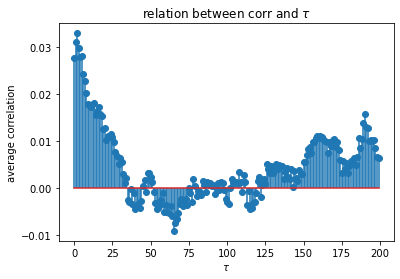

In [67]:
n = 200
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    for i in range(1, n+1):
        try:
            pear = pearsonr(feature[:-i:3], small_df['vol'].shift(-i).fillna(0)[:-i:3])
        except ValueError:
            pear = (0, 1)
        l_corr_list[i-1] += (pear[0]*(pear[1]<0.05))/len(test_names)
        l_corr_list_[i-1] += (pear[0])/len(test_names)

plt.stem(range(n), np.array(l_corr_list))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
plt.title(r'relation between corr and $\tau$')
plt.show()

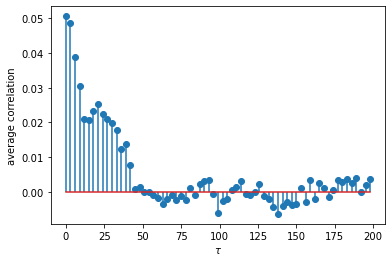

In [57]:
step = 3
plt.stem(range(0,n,step), np.array(l_corr_list[::step]))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()

In [13]:
new_df_vol = nas_100.pivot(index='date', columns='id', values='vol').fillna(0)
new_df_resi = new_df.copy()
aver =  np.array(new_df.T.mean()).reshape(-1,1)
for name in new_df_vol.columns:
    fit_y = new_df_vol[name]
    fit_x = aver
    regression_model = LinearRegression()
    regression_model.fit(fit_x, fit_y)

    # 计算拟合后的残差
    residuals = fit_y - regression_model.predict(fit_x)
    new_df_resi[name] = residuals

<StemContainer object of 3 artists>

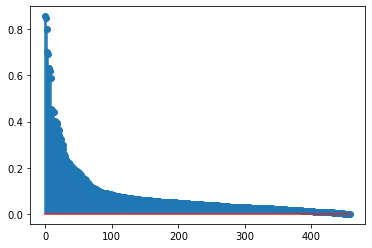

In [41]:
stocks = new_df_resi.columns
corr_list = [abs(pearsonr(new_df_resi[stocks[0]],new_df_resi[stocks[i]])[0]) for i in range(1,len(stocks))]

(corr_list).sort(reverse= True)
plt.stem(range(len(stocks)-1), corr_list)

100%|██████████| 459/459 [00:25<00:00, 18.00it/s]


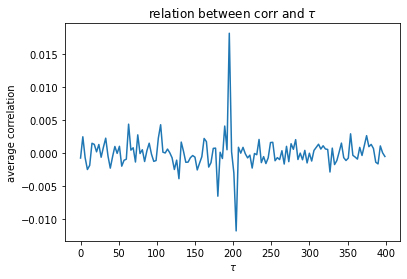

In [15]:
n = 400
step = 3
l_corr_list = [0 for i in range(0,n,step)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    
    X = np.array([feature.shift(j).fillna(0) for j in range(0,n,step)]).T
    Y = small_df['vol'].shift(-1).diff().fillna(0)
    model = LinearRegression()
    model.fit(X, Y)
    for i in range(len(l_corr_list)):
        l_corr_list[i] += model.coef_[i]#/np.sqrt(Y.std())*np.sqrt(X[i].std())
    # l_corr_list[i-1] += (pearsonr(feature[:-i], small_df['vol'].rolling(10).sum().shift(-i)[:-i].fillna(0))[0])/len(bestname)

plt.plot(range(0,n,step), np.array(l_corr_list))
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
plt.title(r'relation between corr and $\tau$')
plt.show()

  0%|          | 0/459 [00:00<?, ?it/s]

100%|██████████| 459/459 [00:23<00:00, 19.38it/s]


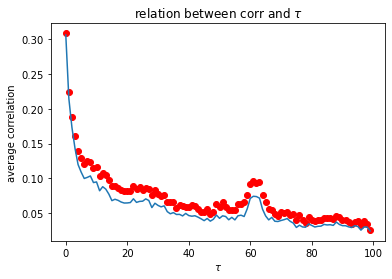

In [16]:
n = 100
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    for i in range(1, n+1):
        try:
            pear = pearsonr(feature[:-i:3], small_df['volume'].shift(-i)[:-i:3])
        except ValueError:
            pear = (0, 1)
        l_corr_list[i-1] += (pear[0]*(pear[1]<0.05))/len(test_names)
        l_corr_list_[i-1] += (pear[0])/len(test_names)

plt.plot(range(n), np.array(l_corr_list))
plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
plt.title(r'relation between corr and $\tau$')
plt.show()

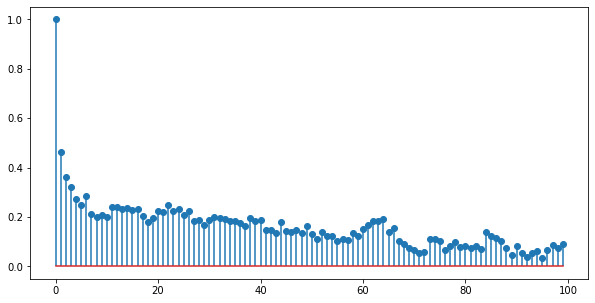

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

small_df = nas_100[nas_100['id']==test_names[1]].copy().dropna()
series = pd.Series(small_df['volume'])

autocorrelation = series.autocorr()

# 计算不同滞后阶数的自相关系数
lags = range(100)
autocorrelations = [series.autocorr(lag) for lag in lags]

plt.figure(figsize=(10, 5))
plt.stem(lags, autocorrelations)
plt.show()

100%|██████████| 459/459 [00:25<00:00, 18.21it/s]


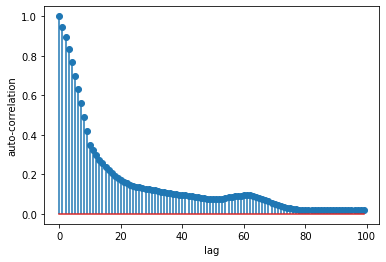

In [18]:
n = 100
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    series = pd.Series(small_df['vol'].fillna(0))

    autocorrelation = series.autocorr()

    # 计算不同滞后阶数的自相关系数
    lags = range(n)
    for lag in lags:
        l_corr_list[lag] += series.autocorr(lag)/len(test_names)

plt.stem(range(n), np.array(l_corr_list))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'lag')
plt.ylabel('auto-correlation')
#plt.title(r'auto')
plt.show()

In [73]:
new_df_vol = nas_100.pivot(index='date', columns='id', values='vol').fillna(0)
new_df_resi = new_df_vol.copy()
aver =  np.array(new_df.T.mean()).reshape(-1,1)
for name in new_df_vol.columns:
    fit_y = new_df_vol[name]
    fit_x = aver
    regression_model = LinearRegression()
    regression_model.fit(fit_x, fit_y)

    # 计算拟合后的残差
    residuals = fit_y - regression_model.predict(fit_x)
    new_df_resi[name] = residuals

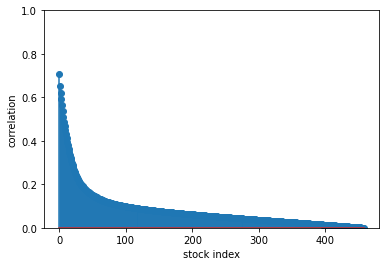

0.08043360587708062


In [74]:
stocks = new_df_resi.columns
corr_list_ = [0 for i in stocks]
for i in range(len(stocks)):
    corr_list = [abs(pearsonr(new_df_resi[stocks[i]],new_df_resi[stocks[j]])[0]) for j in range(len(stocks))]
    (corr_list).sort(reverse= True)
    for j in range(len(stocks)):
        corr_list_[j] += corr_list[j]/len(stocks)
plt.stem(range(len(stocks)-1), corr_list_[1:])
plt.xlabel('stock index')
plt.ylabel('correlation')
plt.ylim(0,1)
plt.show()
print(sum(corr_list_[1:])/(len(corr_list_)-1))